In [1]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import warnings
import math
warnings.filterwarnings('ignore')
from IPython.display import Markdown as md
import astropy.units as u
from astropy.cosmology import LambdaCDM
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


0.2885590072561863

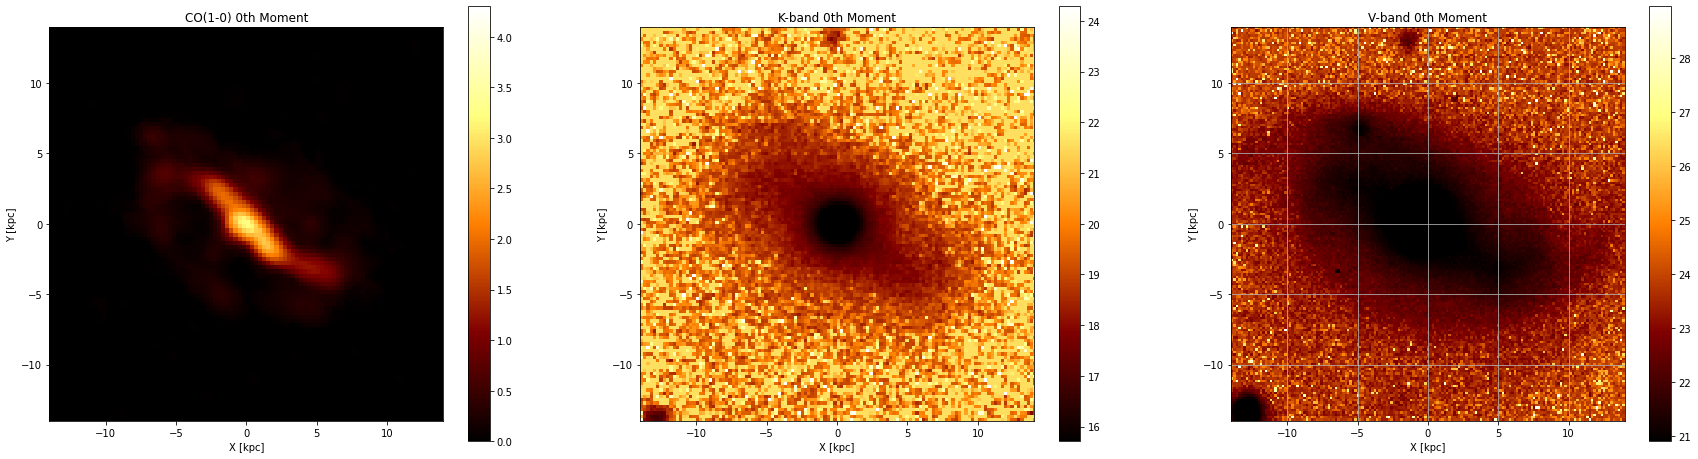

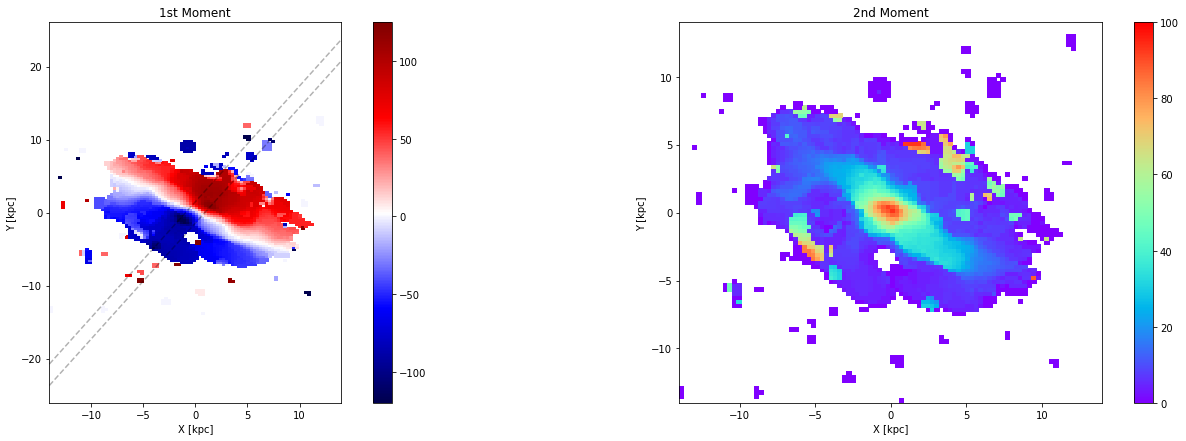

In [16]:
"I will comment with *** the parts you have to change to work for other data cubes"

home = expanduser("~")
datafolder=home+'/Desktop/mrk79/cubes/'  #The folder containing your .fits file
datafolder

mrk79_file='COcube.fits' #.fits file name
mrk79_fileK='mrk79_Kband.fits'
mrk79_fileV='mrk79_Vband.fits'
mrk79_fits=fits.open(datafolder+mrk79_file)[0]
K_fits=fits.open(datafolder+mrk79_fileK)[0]
V_fits=fits.open(datafolder+mrk79_fileV)[0]
K_header=K_fits.header
V_header=V_fits.header
mrk79_header=mrk79_fits.header
mrk79_data=mrk79_fits.data[0]
K_data=K_fits.data
V_data=V_fits.data

dxK=np.abs(K_header['CDELT1'])#*3600
dyK=np.abs(K_header['CDELT2'])#*3600

dxV=np.abs(V_header['CDELT2'])#*3600
dyV=np.abs(V_header['CDELT1'])#*3600

dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s
#print(V_header)
ydecK=np.linspace(-K_data.shape[1]*dyK/2. +K_header["CRVAL2"],K_data.shape[1]*dyK/2.+K_header["CRVAL2"],K_header['NAXIS2'])
xraK=np.linspace(-K_data.shape[0]*dxK/2. +K_header["CRVAL1"],K_data.shape[0]*dxK/2.+K_header["CRVAL1"],K_header['NAXIS1'])
#V_header["CRVAL1"] V_header["CRVAL2"]
ydecV=np.linspace(-V_data.shape[1]*dyV/2 -2*4.161*dyV,V_data.shape[1]*dyV/2-2*4.161*dyV,V_header['NAXIS1'])
xraV=np.linspace(-V_data.shape[0]*dxV/2 -2*4.161*dyV,V_data.shape[0]*dxV/2-2*4.161*dyV,V_header['NAXIS2'])

ydec=np.linspace(-mrk79_data.shape[1]*dy/2. +mrk79_header["CRVAL2"],mrk79_data.shape[1]*dy/2.+mrk79_header["CRVAL2"],mrk79_header['NAXIS2'])
xra=np.linspace(-mrk79_data.shape[2]*dx/2. +mrk79_header["CRVAL1"],mrk79_data.shape[2]*dx/2.+mrk79_header["CRVAL1"],mrk79_header['NAXIS1'])

xx_as=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy_as=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])  #velocity channels

sigma=9.3859574E-4 #noise [Jy/beam] # *** change sigma according to your data 
ns=5 # *** change ns to the threshold you want for the Intensity 
                                           
mrk79_mom0 = np.nansum(np.where(mrk79_data>=ns*sigma,mrk79_data,0),axis=0)*np.abs(dv) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)

vv2=np.linspace(0,0,mrk79_header["NAXIS3"]) 
for i in range(mrk79_header['NAXIS3']):
    vv2[i]=np.where(-300<=vv[i] and vv[i]<=300,vv[i],0) # *** choose which velocities you want to keep 
mrk79_mom1=np.nansum(vv2[:,None,None]*np.where(mrk79_data>=ns*sigma,mrk79_data,0),axis=0)/(mrk79_mom0/np.abs(dv)) #first moment

mrk79_mom2=np.sqrt(np.nansum(np.where(mrk79_data>=ns*sigma,mrk79_data,0)*(vv2[:,None,None]-mrk79_mom1)**2,axis=0)/(mrk79_mom0/np.abs(dv)))

cosmo = LambdaCDM(H0=67.8, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.02219  # *** redshift
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
ak=arctokpc.value
slit=0.9377271654521E-03*ak*3600 #slit width in kpc
dx_kpc=(dx)*ak #dx in kpc  

xx_kpc=xx_as*ak
yy_kpc=yy_as*ak

def yslit_low(x,pa): return slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
def yslit_high(x,pa): return -slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
pos_a=147.8
fig1, axes1 = plt.subplots(1,3,figsize=(30,8))
fig2, axes2 = plt.subplots(1,2,figsize=(25,7))

p0=axes1[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0,vmax=4.3, cmap='afmhot')
axes1[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='CO(1-0) 0th Moment')
fig1.colorbar(p0, ax=axes1[0])

p1=axes2[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
axes2[0].plot(xx_kpc,yslit_low(xx_kpc,pos_a),'--',alpha=0.3, color='black')
axes2[0].plot(xx_kpc,yslit_high(xx_kpc,pos_a),'--',alpha=0.3, color='black')
axes2[0].set(aspect=0.7,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')
fig2.colorbar(p1, ax=axes2[0])

p2=axes2[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom2,vmin=0,vmax=100,cmap='rainbow')
axes2[1].set(aspect=.9,xlabel='X [kpc]',ylabel='Y [kpc]',title='2nd Moment')
fig2.colorbar(p2, ax=axes2[1])

p0K=axes1[1].pcolormesh(xraK*ak,ak*ydecK,K_data,vmin=15.71024,vmax=24.28679, cmap='afmhot')
axes1[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='K-band 0th Moment')
axes1[1].set_xlim([min(xx_kpc),max(xx_kpc)])
axes1[1].set_ylim([min(yy_kpc),max(yy_kpc)])

fig1.colorbar(p0K, ax=axes1[1])

p0V=axes1[2].pcolormesh(ak*xraV, ak*ydecV, V_data,vmin=20.91,vmax=28.960356,cmap='afmhot')
axes1[2].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='V-band 0th Moment')
axes1[2].set_xlim([min(xx_kpc),max(xx_kpc)])
axes1[2].set_ylim([min(yy_kpc),max(yy_kpc)])
axes1[2].grid()
fig1.colorbar(p0V, ax=axes1[2])
dx_kpc

In [25]:

def model_rc(r, mb, ab, md, ad, hz1): #mc,ac,hz2):
    #UM= M_sun UV=
    mb=abs(mb); ab=abs(ab);  ad=abs(ad); hz1=abs(hz1)
    G=4.3*10**(-3)
    ab=ab*1e3
    ad=ad*1e3
    hz1=hz1*1e3
    r=r*1e3 #to pc
    vcirc=np.sqrt(ibul* (G*mb*r**2/(r**2+ab**2)**(3/2)) + idisk* (G*md*r**2/(r**2+(abs(ad)+abs(hz1))**2)**(3/2)))# + ind* (G*um*mc*r**2/(r**2+(ac+hz2)**2)**(3/2))**2)
    
    #vcirc=np.sqrt(ibul* (G*abs(mb)*abs(r)/(abs(r)+abs(ab))**2)**2 + idisk* (G*abs(md)*r**2/(r**2+(abs(ad)+abs(hz1))**2)**(3/2))**2)# + ind* (G*um*mc*r**2/(r**2+(ac+hz2)**2)**(3/2))**2)

    return vcirc

def bulge_disp(r,m,a):
    G=4.3*10**(-3)
    a=a*1e3
    r=r*1e3
    u2r=G*m/(12*a) *(12*r*(r+a)**3/a**4 *np.log((r+a)/r)-r/(r+a) *(25+52*r/a +42*(r/a)**2 +12*(r/a)**3))
    return u2r

def bh(r,mbh,a, md, ad, hz1):
    a=a*10**3
    r=r*10**3
    G=4.3E-3
    vcir=np.sqrt((G*mbh/(r+a)**2)**2 + (G*abs(md)*r**2/(r**2+(abs(ad)+abs(hz1))**2)**(3/2))**2)
    return vcir

Parameters after fit:
 mb: 1.4423e+10 Msun
 ab: 6.5125e-01 kpc
 md: 5.8867e+10 Msun
 ad: 3.3161e+00 kpc
 hz: 4.7357e-01 kpc


-5.317118167877

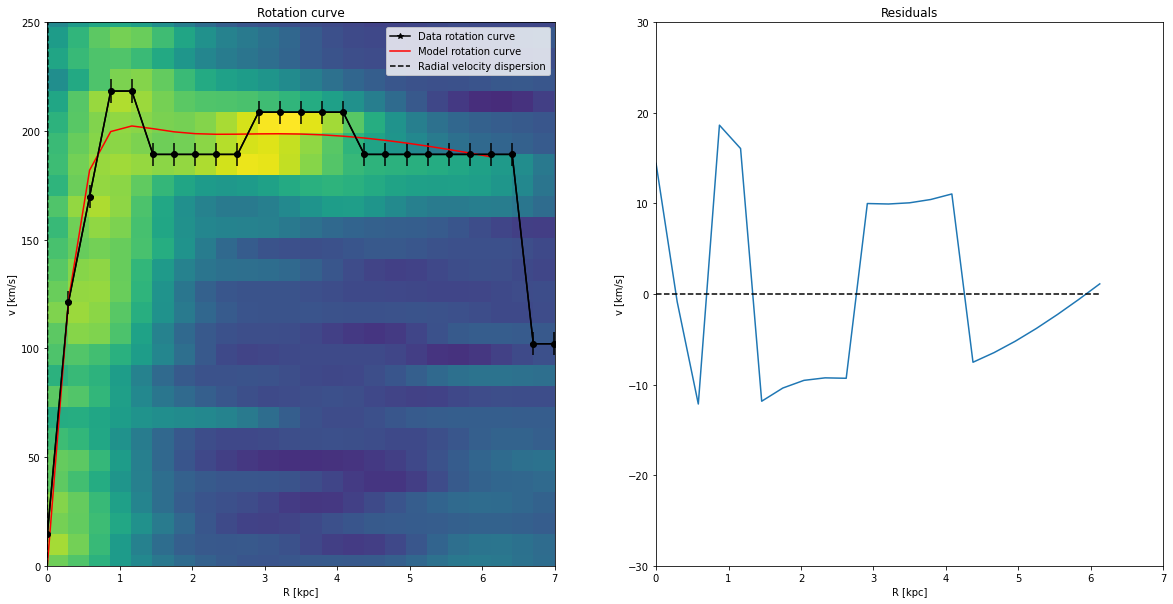

In [29]:
ithick = int((slit/dx_kpc)) 
ixc = round(mrk79_data.shape[2]/2)
rotcube=ndimage.interpolation.rotate(mrk79_data,pos_a+180,axes=(2,1),reshape=False) 
pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)
incl=np.deg2rad(33.2)

vmaxslit=np.linspace(0,0,mrk79_header['NAXIS1'])
for k in range(mrk79_header['NAXIS1']):
    pvd_cubemax=0
    for m in range(mrk79_header['NAXIS3']):
        if pvd_cubemax<=pvd_cube[m,k]:
            pvd_cubemax=pvd_cube[m,k]
            index=m
    vmaxslit[k]=vv[int(index)]
vmaxslit=abs(vmaxslit/np.sin(incl))

fig, axes = plt.subplots(1,2,figsize=(20,10))
vec1=48; vec2=70;

axes[0].plot(xx_kpc,vmaxslit,'k-*',label='Data rotation curve')
axes[0].errorbar(xx_kpc,vmaxslit,yerr=dv,fmt='k-o')
axes[0].set(xlabel='R [kpc]',ylabel='v [km/s]',title='Rotation curve')

axes[0].set_xlim([0,7])
axes[0].set_ylim([0,250])
R_model=xx_kpc[vec1:vec2]

global ibul, idisk, ind
ibul=1; idisk=1; ind=1

pop2=curve_fit(model_rc, R_model , vmaxslit[vec1:vec2], bounds=([0,0,0,0,0],[1e11,2,5e11,7,1]))
#po=curve_fit(bh, R_model, vmaxslit[vec1:vec2], bounds=([5e+2,0,0,0,0],[5e+8,1,1e+9,50,1]))
axes[0].plot(R_model, model_rc(R_model,*pop2[0]),'r', label='Model rotation curve')
axes[0].plot(R_model, bulge_disp(R_model,pop2[0][0],pop2[0][1]),'k--', label='Radial velocity dispersion')
axes[0].pcolormesh(xx_kpc, vv/np.sin(incl), pvd_cube, cmap=None)
#axes[0].plot(R_model, bh(R_model,*po[0]),'b-*',label='bh')
axes[0].legend()

axes[1].plot(R_model,vmaxslit[vec1:vec2]-model_rc(R_model,*pop2[0]))
axes[1].plot(R_model,np.linspace(0,0,vec2-vec1),'k--')
axes[1].set(xlabel='R [kpc]',ylabel='v [km/s]',title='Residuals')

axes[1].set_xlim([0,7])
axes[1].set_ylim([-30,30])

print("Parameters after fit:\n",
     'mb:',"{:.4e}".format(pop2[0][0]),'Msun\n',
     'ab:',"{:.4e}".format(pop2[0][1]),'kpc\n',
     'md:',"{:.4e}".format(pop2[0][2]),'Msun\n',
     'ad:',"{:.4e}".format(pop2[0][3]),'kpc\n',
     'hz:',"{:.4e}".format(pop2[0][4]),'kpc')
dv

1.2584244902138082

Parameters after fit:
 mb: 1.6485e+10 Msun
 ab: 6.0000e-01 kpc
 md: 6.5575e+10 Msun
 ad: 4.0744e+00 kpc
 hz: 3.4211e-01 kpc


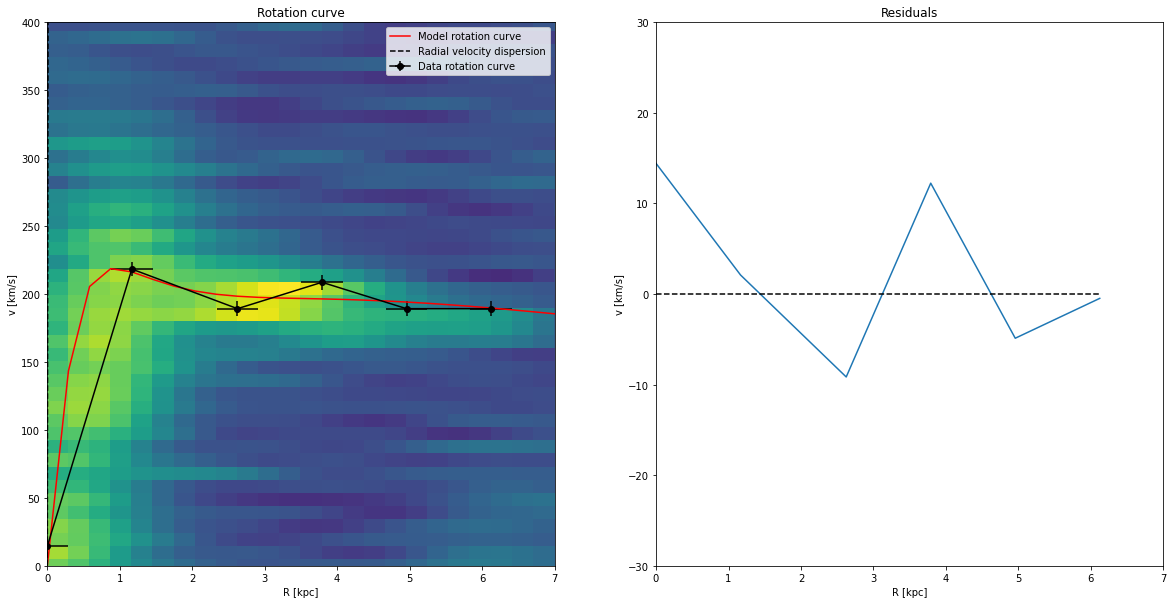

In [37]:
slitlen=int((((xx_kpc[-1]-xx_kpc[int(len(xx_kpc)/2)])/slit))) #slit length in points with distance=slit between them 
#xx_slit=np.linspace(xx_kpc[int(len(xx_kpc)/2)], xx_kpc[-1], slitlen)
sl_pix=(48*slit/(xx_kpc[-1]-xx_kpc[int(len(xx_kpc)/2)]))-1
slitlen=int((97-48)/sl_pix)
display(sl_pix*dx_kpc)
pvd_cube_sl=np.zeros(shape=(190,slitlen))
#display(slitlen)
xx_slit=np.linspace(0,0,slitlen)
for i in range(slitlen): 
    xx_slit[i]=xx_kpc[int(len(xx_kpc)/2+i*sl_pix)]
    if i==int(slitlen-6):
        xx_slit[i]=xx_kpc[int(len(xx_kpc)/2+(i)*sl_pix-1)]
for i in range(slitlen): 
    pvd_cube_sl[:,i]=pvd_cube[:,int(len(xx_kpc)/2+i*sl_pix)]
    if i==int(slitlen-6):
        pvd_cube_sl[:,i]=pvd_cube[:,int(len(xx_kpc)/2+i*sl_pix-1)]
    
vmaxslit=np.linspace(0,0,int(slitlen))

for k in range(slitlen):
    pvd_cubemax=0
    index=0
    for m in range(mrk79_header['NAXIS3']):
        if pvd_cubemax<=pvd_cube_sl[m,k]:
            pvd_cubemax=pvd_cube_sl[m,k]
            index=m
    vmaxslit[k]=vv[int(index)]
vmaxslit=abs(vmaxslit/np.sin(incl))


fig, axes = plt.subplots(1,2,figsize=(20,10))
vec1=0; vec2=6;
R_model=xx_slit[vec1:vec2]

axes[0].errorbar(R_model,vmaxslit[vec1:vec2],xerr=dx_kpc,yerr=dv,fmt='k-o',label='Data rotation curve')
axes[0].set(xlabel='R [kpc]',ylabel='v [km/s]',title='Rotation curve')

axes[0].set_xlim([0,7])
axes[0].set_ylim([0,400])
global ibul, idisk, ind
ibul=1; idisk=1; ind=1
pop=curve_fit(model_rc, R_model , vmaxslit[vec1:vec2],bounds=([0,0.6,0,2,0],[10e10,5,1e11,8,1]))  #mb, ab, md, ad, hz1

axes[0].plot(xx_kpc[48:], model_rc(xx_kpc[48:],*pop[0]),'r', label='Model rotation curve')
axes[0].plot(xx_kpc[48:], bulge_disp(xx_kpc[48:],pop[0][0],pop[0][1]),'k--', label='Radial velocity dispersion')
axes[0].pcolormesh(xx_kpc, vv/np.sin(incl), pvd_cube)


axes[0].legend()
axes[1].plot(R_model,vmaxslit[vec1:vec2]-model_rc(R_model,*pop[0])[vec1:vec2])
axes[1].plot(R_model,np.linspace(0,0,vec2-vec1),'k--')

axes[1].set(xlabel='R [kpc]',ylabel='v [km/s]',title='Residuals')

axes[1].set_xlim([0,7])
axes[1].set_ylim([-30,30])

#R_model=xx_kpc[48:90]

#axes[0].plot(R_model, model_rc(R_model,*pop2[0]), label='Model rotation curve')
#axes[0].plot(R_model, vmaxslit2[48:90], label='Data rot curve 1')

print("Parameters after fit:\n",
     'mb:',"{:.4e}".format(pop[0][0]),'Msun\n',
     'ab:',"{:.4e}".format(pop[0][1]),'kpc\n',
     'md:',"{:.4e}".format(pop[0][2]),'Msun\n',
     'ad:',"{:.4e}".format(pop[0][3]),'kpc\n',
     'hz:',"{:.4e}".format(pop[0][4]),'kpc')
#dx_kpc